In [19]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
import os

## Reading data
Let's define some functions to read data from the CSV files. We are storing an array of actions for each line.

In [4]:
def read_train(file):
    ids = []
    data = []
    with open(file,'r') as f:
        for line in f:
            line_data = line.replace('\n','').split(',')
            battlenet_id, race, actions = line_data[0],line_data[1],line_data[2:]
            battlenet_id=battlenet_id.split('/')
            ids.append(battlenet_id[8])
            data.append([race, ", ".join([a.strip() for a in actions])])
    df = pd.DataFrame(data, columns=['race','actions'])
    series = pd.Series(ids)
    return df, series

def read_test(file):
    data = []
    with open(file,'r') as f:
        for line in f:
            line_data = line.replace('\n','').split(',')
            race, actions = line_data[0],line_data[1:]
            data.append([race, ", ".join([a.strip() for a in actions])])
    df = pd.DataFrame(data, columns=['race','actions'])
    return df
        

In [5]:
folder = '../'
train_data, train_ids = read_train(folder + 'TRAIN.CSV')
train_data.head()

,race,actions
0,Protoss,"Base, s, s, s, s, s, t5, Base, s, hotkey30, ho..."
1,Protoss,"s, Base, s, s, Base, s, s, Base, s, t5, hotkey..."
2,Protoss,"Base, s, s, s, Base, s, hotkey30, hotkey00, t5..."
3,Protoss,"Base, s, s, Base, s, s, s, t5, Base, s, hotkey..."
4,Protoss,"Base, s, s, s, Base, s, hotkey30, hotkey00, t5..."


In [6]:
test_data = read_test(folder + 'TEST.CSV')
test_data.head()

,race,actions
0,Zerg,"s, s, s, hotkey10, s, hotkey60, s, hotkey00, s..."
1,Terran,"s, hotkey30, hotkey00, t5, s, hotkey32, s, hot..."
2,Protoss,"Base, s, s, Base, s, hotkey20, hotkey30, hotke..."
3,Zerg,"s, s, s, s, hotkey20, s, hotkey40, t5, t10, ho..."
4,Protoss,"Base, s, s, Base, s, hotkey50, hotkey30, t5, h..."


In [7]:
print(train_ids)

0          First
1       Stardust
2          First
3       Stardust
4          First
          ...   
3047         MMA
3048    STBomber
3049         MMA
3050    STBomber
3051         MMA
Length: 3052, dtype: object


we consider just pseudo to increase accurancy

### List of actions (hotkeys)

In [8]:
def find_unique_actions(df):
    unique_actions = set()
    actions = df['actions']
    for action in actions:
        for a in action.split(','):
            a = a.strip()
            if a!='' and a[0]!='t':
                unique_actions.add(a)
    return unique_actions

unique_hotkeys = sorted(list(find_unique_actions(train_data)))
print(unique_hotkeys)

keys = list(set([hotkey[:len(hotkey)-1] for hotkey in unique_hotkeys if 'hotkey' in hotkey]))
print(keys)
    

['Base', 'SingleMineral', 'hotkey00', 'hotkey01', 'hotkey02', 'hotkey10', 'hotkey11', 'hotkey12', 'hotkey20', 'hotkey21', 'hotkey22', 'hotkey30', 'hotkey31', 'hotkey32', 'hotkey40', 'hotkey41', 'hotkey42', 'hotkey50', 'hotkey51', 'hotkey52', 'hotkey60', 'hotkey61', 'hotkey62', 'hotkey70', 'hotkey71', 'hotkey72', 'hotkey80', 'hotkey81', 'hotkey82', 'hotkey90', 'hotkey91', 'hotkey92', 's']
['hotkey2', 'hotkey3', 'hotkey6', 'hotkey7', 'hotkey5', 'hotkey1', 'hotkey9', 'hotkey4', 'hotkey0', 'hotkey8']


## Defining features
We are defining features as the race and the number of clicks on the hotkeys in the first X seconds ( here 30 , 60,90,120,150,180,210)



In [9]:
hotkey_columns = ['first_hotkey','second_hotkey','third_hotkey','fourth_hotkey','fifth_hotkey','sixth_hotkey','seventh_hotkey','eighth_hotkey']

le = preprocessing.LabelEncoder()



def generate_features(df):
    features = []
    hotkeys = unique_hotkeys
    set_hotkeys = set(hotkeys)
    for index, row in df.iterrows():
        first_hotkeys = []
        race = row["race"]
        actions = row["actions"]
        hotkeys_count = {hotkey:0 for hotkey in hotkeys}
        hotkeys_count_t30 = {hotkey:0 for hotkey in hotkeys}
        hotkeys_count_t60 = {hotkey:0 for hotkey in hotkeys}
        hotkeys_count_t90 = {hotkey:0 for hotkey in hotkeys}
        hotkeys_count_t120 = {hotkey:0 for hotkey in hotkeys}
        hotkeys_count_t150 = {hotkey:0 for hotkey in hotkeys}
        hotkeys_count_t180 = {hotkey:0 for hotkey in hotkeys}
        hotkeys_count_t210 = {hotkey:0 for hotkey in hotkeys}
        t30 = False
        t60 = False
        t90 = False
        t120 = False
        t150 = False
        t180 = False
        t210 = False
        keys_count = {key:0 for key in keys}
        for action in actions.split(','):
            action = action.strip()
            if action in set_hotkeys:
                hotkeys_count[action]+=1
                if not t30:
                    hotkeys_count_t30[action]+=1
                if not t60:
                    hotkeys_count_t60[action]+=1
                if not t90:
                    hotkeys_count_t90[action]+=1
                if not t120:
                    hotkeys_count_t120[action]+=1
                if not t150:
                    hotkeys_count_t150[action]+=1
                if not t180:
                    hotkeys_count_t180[action]+=1
                if not t180:
                    hotkeys_count_t210[action]+=1
            if 'hotkey' in action:
                keys_count[action[:len(action)-1]]+=1
            if len(first_hotkeys)<len(hotkey_columns) and 'hotkey' in action:
                first_hotkeys.append(action)
                
            if 't30' in action:
                t30 = False
            elif 't60' in action:
                t60 = True
            elif 't90' in action:
                t90 = True
            elif 't120' in action:
                t120 = True
            elif 't150' in action:
                t150 = True
            elif 't180' in action:
                t180 = True
            elif 't180' in action:
                t210 = True
                
        while len(first_hotkeys)<len(hotkey_columns):
            first_hotkeys.append('None')
        current = [race, *[hotkeys_count[hotkey] for hotkey in hotkeys],*[hotkeys_count_t30[hotkey] for hotkey in hotkeys],*[hotkeys_count_t60[hotkey] for hotkey in hotkeys],*[hotkeys_count_t90[hotkey] for hotkey in hotkeys], *[hotkeys_count_t120[hotkey] for hotkey in hotkeys],*[hotkeys_count_t150[hotkey] for hotkey in hotkeys],*[hotkeys_count_t180[hotkey] for hotkey in hotkeys],*[hotkeys_count_t210[hotkey] for hotkey in hotkeys], *[keys_count[key] for key in keys], *first_hotkeys]
        features.append(current)
    new_df = pd.DataFrame(features, columns=['race', *hotkeys,*[hotkey+'_t30' for hotkey in hotkeys],*[hotkey+'_t60' for hotkey in hotkeys],*[hotkey+'_t90' for hotkey in hotkeys],*[hotkey+'_t120' for hotkey in hotkeys],*[hotkey+'_t150' for hotkey in hotkeys],*[hotkey+'_t180' for hotkey in hotkeys],*[hotkey+'_t210' for hotkey in hotkeys], *keys, *hotkey_columns])
    return new_df

In [10]:
train_features = generate_features(train_data)
for col in hotkey_columns:
    train_features[col] = le.fit_transform(train_features[col]) 
train_features.columns.values

array(['race', 'Base', 'SingleMineral', 'hotkey00', 'hotkey01',
       'hotkey02', 'hotkey10', 'hotkey11', 'hotkey12', 'hotkey20',
       'hotkey21', 'hotkey22', 'hotkey30', 'hotkey31', 'hotkey32',
       'hotkey40', 'hotkey41', 'hotkey42', 'hotkey50', 'hotkey51',
       'hotkey52', 'hotkey60', 'hotkey61', 'hotkey62', 'hotkey70',
       'hotkey71', 'hotkey72', 'hotkey80', 'hotkey81', 'hotkey82',
       'hotkey90', 'hotkey91', 'hotkey92', 's', 'Base_t30',
       'SingleMineral_t30', 'hotkey00_t30', 'hotkey01_t30',
       'hotkey02_t30', 'hotkey10_t30', 'hotkey11_t30', 'hotkey12_t30',
       'hotkey20_t30', 'hotkey21_t30', 'hotkey22_t30', 'hotkey30_t30',
       'hotkey31_t30', 'hotkey32_t30', 'hotkey40_t30', 'hotkey41_t30',
       'hotkey42_t30', 'hotkey50_t30', 'hotkey51_t30', 'hotkey52_t30',
       'hotkey60_t30', 'hotkey61_t30', 'hotkey62_t30', 'hotkey70_t30',
       'hotkey71_t30', 'hotkey72_t30', 'hotkey80_t30', 'hotkey81_t30',
       'hotkey82_t30', 'hotkey90_t30', 'hotkey91_t30', 

In [11]:
train_features = pd.get_dummies(train_features, columns = ['race']) # convert race to integers
for col in hotkey_columns:
    train_features[col] = le.fit_transform(train_features[col]) 
train_features.head()

,Base,SingleMineral,hotkey00,hotkey01,hotkey02,hotkey10,hotkey11,hotkey12,hotkey20,hotkey21,...,second_hotkey,third_hotkey,fourth_hotkey,fifth_hotkey,sixth_hotkey,seventh_hotkey,eighth_hotkey,race_Protoss,race_Terran,race_Zerg
0,66,5,5,0,41,63,0,350,37,0,...,1,10,9,10,10,9,9,1,0,0
1,12,0,2,0,83,65,3,448,15,0,...,11,10,9,10,10,9,9,1,0,0
2,47,3,3,0,18,17,0,130,9,0,...,1,10,9,10,10,9,9,1,0,0
3,21,0,2,0,39,32,1,259,14,0,...,11,10,9,10,10,9,9,1,0,0
4,2,0,1,0,0,10,0,52,6,0,...,1,10,9,10,10,9,9,1,0,0


In [12]:
id=train_ids.to_numpy()
print(id)

['First' 'Stardust' 'First' ... 'MMA' 'STBomber' 'MMA']


In [13]:

x_train, x_test, y_train, y_test = train_test_split(train_features, train_ids, stratify=id, test_size=0.30)


In [15]:
#from imblearn.over_sampling import ADASYN

#ada = ADASYN(sampling_strategy='minority', random_state= 420 , n_neighbors = 2)

#x_train, y_train = ada.fit_resample(x_train, y_train)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [13]:
# Amélioration de 0.03 avec smote ce qui est pas mal du tout
#smt = SMOTE()
#train_freatures, train_ids = smt.fit_sample(train_features, train_ids)
#ada = ADASYN(sampling_strategy='minority', random_state= 420 , n_neighbors = 2)

#train_freatures, train_ids = ada.fit_resample(train_features, train_ids)

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_freatures = scaler.fit_transform(train_freatures)


In [19]:
test_features = generate_features(test_data)
test_features = pd.get_dummies(test_features, columns = ['race']) # convert race to integers
for col in hotkey_columns:
    test_features[col] = le.fit_transform(test_features[col]) 

'''
# Get missing columns in the training test
missing_cols = set( train_features.columns ) - set( test_features.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    test_features[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
test_features = test_features[train_features.columns]
'''

test_features.head()

,Base,SingleMineral,hotkey00,hotkey01,hotkey02,hotkey10,hotkey11,hotkey12,hotkey20,hotkey21,...,second_hotkey,third_hotkey,fourth_hotkey,fifth_hotkey,sixth_hotkey,seventh_hotkey,eighth_hotkey,race_Protoss,race_Terran,race_Zerg
0,19,3,14,0,847,7,31,352,10,0,...,15,1,21,3,2,16,3,0,0,1
1,0,0,2,0,33,14,0,336,31,0,...,1,10,9,9,8,9,9,0,1,0
2,20,0,1,0,0,10,0,479,53,0,...,9,15,10,20,16,16,16,1,0,0
3,17,2,0,0,0,68,89,525,13,6,...,11,7,12,11,10,11,7,0,0,1
4,21,0,3,0,0,4,7,74,8,0,...,9,11,14,14,12,13,14,1,0,0


In [16]:
scaler = StandardScaler()
test_features = scaler.fit_transform(test_features)

## Predicting players

In [21]:
def read_csv_head(path):
    with open(path, 'r') as f:
        c = 0
        for line in f:
            print(line)
            c+=1
            if c==10:
                break

def convert(output):
    output_df = pd.DataFrame(output, columns=['prediction'])
    output_df.index = range(1,len(output_df)+1)
    output_df.index.name = 'RowId'
    return output_df

def save(output_df, name):
    output_df.to_csv('./out_'+name+'.csv')

###  Random Forest

In [16]:
classifier = RandomForestClassifier(random_state=13 ,n_estimators=800)
classifier.fit(x_train,y_train)
y_predict = classifier.predict(x_test)
f1_score(y_test, y_predict, average='micro')

0.962882096069869

In [17]:
# Get numerical feature importances
feature_list=list(train_features.columns)
importances = list(classifier.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: Base                 Importance: 0.01
Variable: hotkey32             Importance: 0.01
Variable: hotkey42             Importance: 0.01
Variable: hotkey52             Importance: 0.01
Variable: hotkey62             Importance: 0.01
Variable: Base_t30             Importance: 0.01
Variable: hotkey32_t30         Importance: 0.01
Variable: hotkey42_t30         Importance: 0.01
Variable: hotkey52_t30         Importance: 0.01
Variable: hotkey62_t30         Importance: 0.01
Variable: hotkey10_t60         Importance: 0.01
Variable: hotkey12_t60         Importance: 0.01
Variable: hotkey20_t60         Importance: 0.01
Variable: hotkey22_t60         Importance: 0.01
Variable: hotkey30_t60         Importance: 0.01
Variable: hotkey32_t60         Importance: 0.01
Variable: hotkey40_t60         Importance: 0.01
Variable: hotkey42_t60         Importance: 0.01
Variable: hotkey50_t60         Importance: 0.01
Variable: hotkey52_t60         Importance: 0.01
Variable: s_t60                Importanc

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

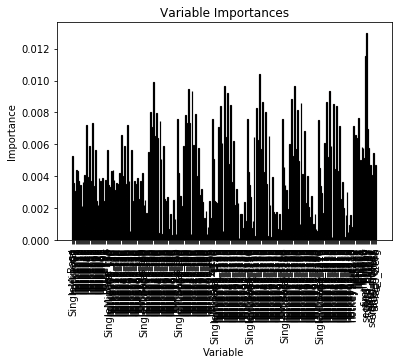

In [20]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

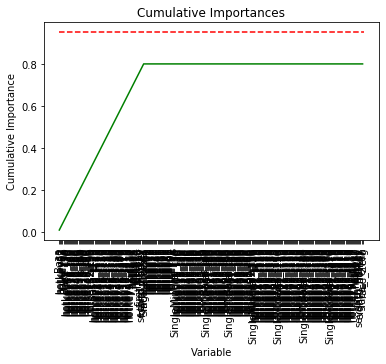

In [21]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [ ]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

In [ ]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:92]]
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]


# Sanity check on operations
print('Important train features shape:', important_indices)


In [20]:
from sklearn.metrics import multilabel_confusion_matrix
print('Confusion Matrix - Training Dataset')
multilabel_confusion_matrix(y_test, y_predict, labels=id)

Confusion Matrix - Training Dataset


array([[[911,   0],
        [  0,   5]],

       [[905,   0],
        [  0,  11]],

       [[911,   0],
        [  0,   5]],

       ...,

       [[915,   0],
        [  0,   1]],

       [[910,   1],
        [  1,   4]],

       [[915,   0],
        [  0,   1]]], dtype=int64)

In [ ]:
n_estimators=range(100,1000,100)
hyper={'n_estimators':n_estimators}
gd=GridSearchCV(estimator=RandomForestClassifier(random_state=13),param_grid=hyper,verbose=True)
gd.fit(X_train,y_train)
print(gd.best_score_)
print(gd.best_estimator_)

In [17]:
rf = RandomForestClassifier(random_state=13, n_estimators=800)
rf.fit(train_features,train_ids)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=13, verbose=0,
                       warm_start=False)

In [22]:

predicted_ids_rf = rf.predict(test_features)
predicted_ids_rf_df = convert(predicted_ids_rf)
save(predicted_ids_rf_df, 'randomforesttest5') # test 1 , smote k = 2 / test 2 , smote k=3 => resultats 3 moins efficace ?
#test3 adasyn # test 4 ada de ade # ade + scaled # on enlève id
predicted_ids_rf_df.head()

,prediction
RowId,
1,Golden
2,MÇ‚ForGG
3,yoeFWSan
4,VortiX
5,Grubby
